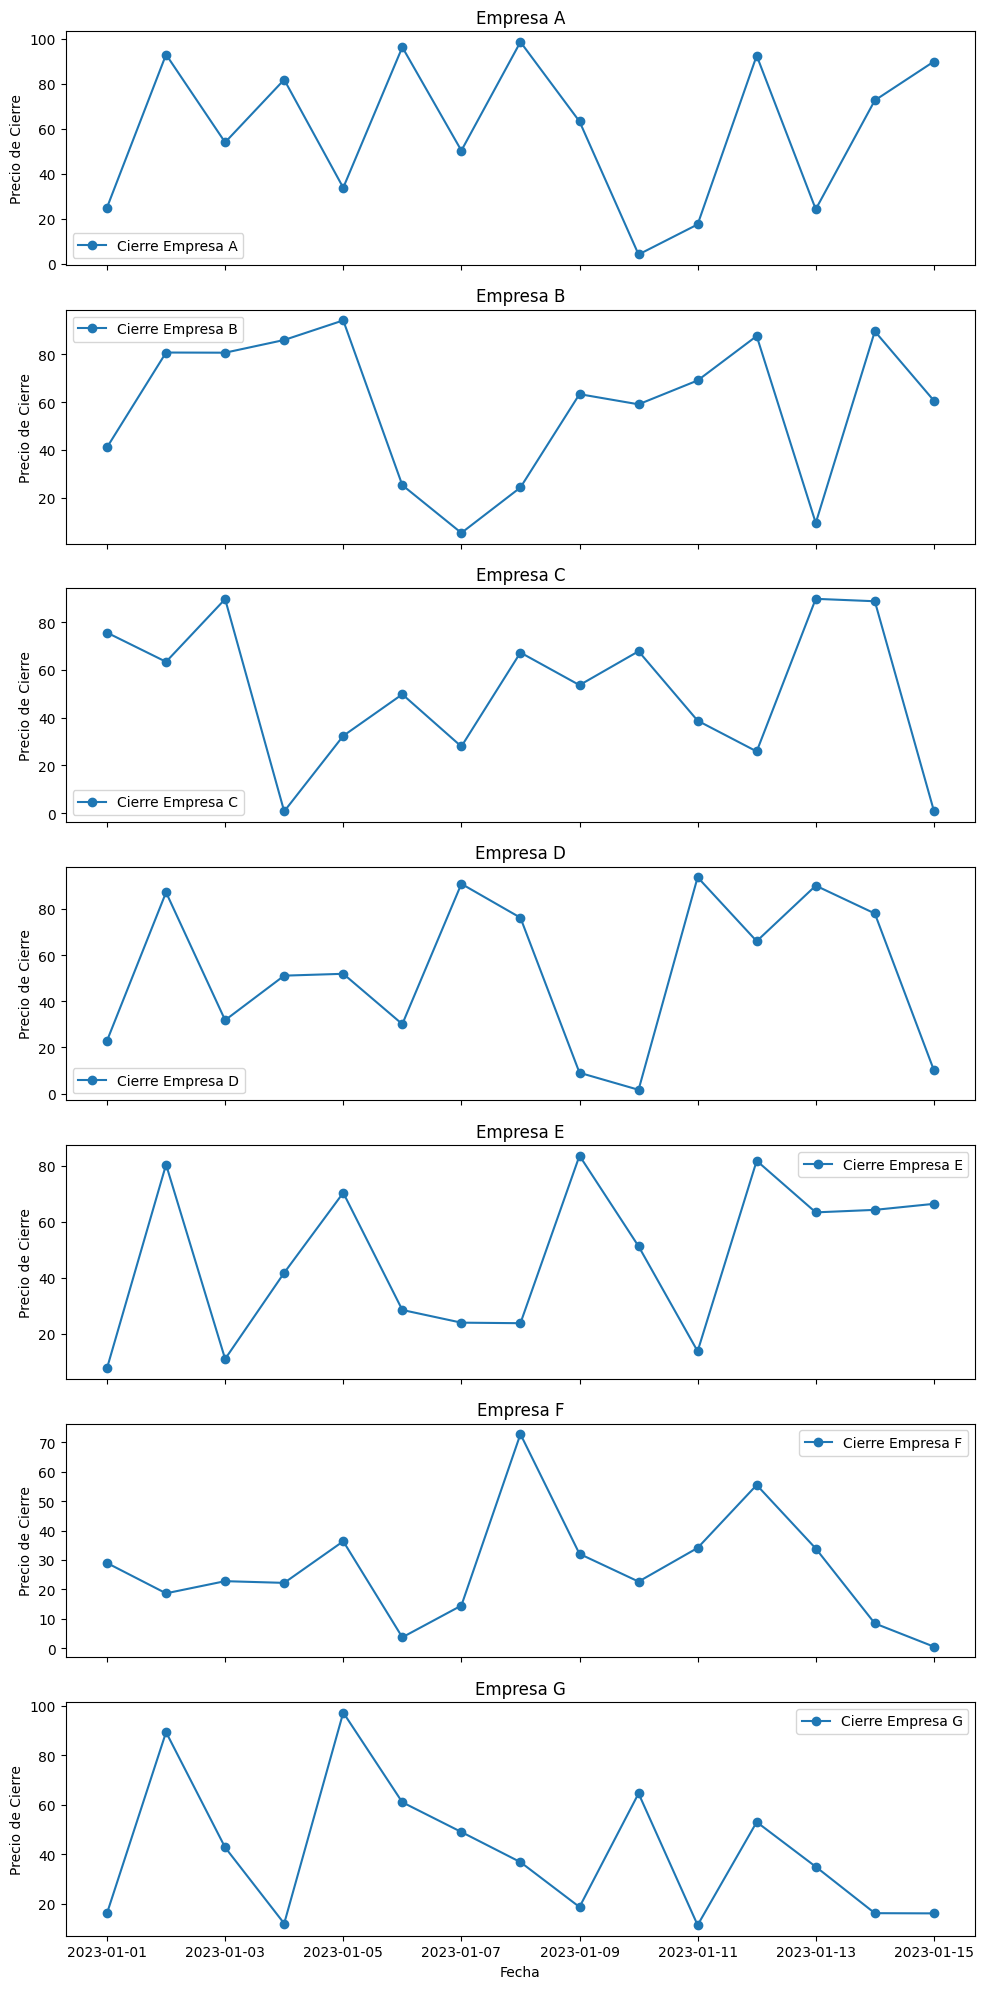

In [13]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Cargar el dataset de acuerdo a tu especificación
data = pd.read_csv('dataset_precios_acciones_DEMO.csv')

# Convertir la columna 'Fecha' a tipo datetime para asegurar la correcta visualización en el gráfico
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Obtener la lista de empresas del dataset
empresas = data['Nombre de la Empresa'].unique()

# Gráfico evolutivo del precio de los activos de cada empresa
fig, axs = plt.subplots(len(empresas), 1, figsize=(10, 20), sharex=True)

for idx, empresa in enumerate(empresas):
    df_empresa = data[data['Nombre de la Empresa'] == empresa]
    axs[idx].plot(df_empresa['Fecha'], df_empresa['Cierre'], marker='o', linestyle='-', label=f"Cierre {empresa}")
    axs[idx].set_title(empresa)
    axs[idx].set_ylabel('Precio de Cierre')
    axs[idx].legend()

plt.xlabel('Fecha')
plt.tight_layout()
plt.show()


## DEMO Mean-Variance Portfolio Optimization

Este método busca encontrar la combinación de activos óptima que minimice el riesgo (varianza) y maximice el retorno esperado. Utiliza los retornos esperados de los activos y sus riesgos (volatilidad) para determinar los pesos óptimos de cada activo en el portfolio.

La formulación matemática del problema es la siguiente:
\begin{align*}
& \text{minimizar} & & \mathbf{w}^T \Sigma \mathbf{w} \\
& \text{sujeto a:} & & \mathbf{w}^T \boldsymbol{\mu} = R \\
& & & \mathbf{w}^T \mathbf{1} = 1 \\
& & & w_i \geq 0, \quad \text{para todo } i
\end{align*}

Donde:
- $\mathbf{w}$ = Vector de pesos de los activos en el portfolio
- $\Sigma$ = Matriz de covarianza de los retornos de los activos
- $\boldsymbol{\mu}$ = Vector de retornos esperados de los activos
- $R$ = Retorno esperado objetivo del portafolio
- $\mathbf{1}$ = Vector de unos que representa la restricción de que la suma de los pesos debe ser 1 (todo el capital se invierte)




In [14]:
# Cargar el conjunto de datos de precios de activos
data = pd.read_csv('dataset_precios_acciones_DEMO.csv')

# Calcular los retornos diarios para cada empresa, centrándonos en el valor de cierre porque es más representativo
data['Retorno'] = data.groupby('Nombre de la Empresa')['Cierre'].pct_change()

# Eliminar filas con NaN resultantes del cálculo de retornos
data.dropna(inplace=True)

# Transformar los datos para tener las empresas en columnas y los retornos diarios en filas
datos_transform = data.pivot(index='Fecha', columns='Nombre de la Empresa', values='Retorno')

# Calcular los retornos esperados (media) y la matriz de covarianza de los retornos
retornos_esperados = datos_transform.mean()
matriz_covarianza = datos_transform.cov()

# Imprimir los retornos esperados y la matriz de covarianza
print("Retornos Esperados Anuales de cada Empresa:")
print(retornos_esperados*252)  # Para que sean anuales
print("\nMatriz de Covarianza de los Retornos:")
print(matriz_covarianza)

# Número de activos en el portafolio
num_assets = len(retornos_esperados)

# Función objetivo: Minimizar la varianza del portafolio
def varianza_portfolio(weights):
    return weights.T @ matriz_covarianza @ weights

# Restricciones
restricciones = [
    {'type': 'eq', 'fun': lambda weights: weights.sum() - 1},  # La suma de los pesos debe ser 1
    {'type': 'eq', 'fun': lambda weights: np.dot(weights, retornos_esperados) - 0.10}  # Retorno esperado objetivo R = 10% (por ejemplo)
]

# Límites para los pesos de cada activo (entre 0 y 1)
limites_pesos = tuple((0, 1) for asset in range(num_assets))

# Estimación inicial de los pesos (distribución igualitaria)
estimacion_inic = num_assets * [1. / num_assets,]

# Resolver el problema de optimización
result_opt = minimize(varianza_portfolio, estimacion_inic, method='SLSQP', bounds=limites_pesos, constraints=restricciones)

# Pesos óptimos del portafolio
pesos_optimos = result_opt.x

# Imprimir los pesos óptimos del portafolio asignados a cada empresa
print("\nPesos óptimos del portfolio asignados a cada empresa:")
for i, weight in enumerate(pesos_optimos):
    print(f"{datos_transform.columns[i]}: {weight:.4f}")

print()
print("Pesos óptimos del portfolio:", pesos_optimos)


Retornos Esperados Anuales de cada Empresa:
Nombre de la Empresa
Empresa A     222.463879
Empresa B     228.784151
Empresa C     846.694151
Empresa D    1027.280435
Empresa E     314.165472
Empresa F      85.172454
Empresa G     243.199205
dtype: float64

Matriz de Covarianza de los Retornos:
Nombre de la Empresa  Empresa A  Empresa B   Empresa C   Empresa D  Empresa E  \
Nombre de la Empresa                                                            
Empresa A              2.828224   1.003925   -5.531324   10.520119   2.251006   
Empresa B              1.003925   6.345361   -2.761708   -3.400247  -0.022920   
Empresa C             -5.531324  -2.761708  147.881725  -16.590809  -2.690001   
Empresa D             10.520119  -3.400247  -16.590809  219.980645  -6.653920   
Empresa E              2.251006  -0.022920   -2.690001   -6.653920   8.325987   
Empresa F             -0.109976   0.167764    1.289120    1.122000  -0.581954   
Empresa G              0.417383  -0.936453   21.250889   -

Como podemos observar, la empresa F es la única que tiene un peso de 1, por lo que sugiere que toda la inversión debería ir a la empresa F puesto que, dadas las restricciones del problema, esta empresa proporciona el mejor equilibrio de retorno y riesgo.